# 1. Magdwich AHRS with IMU

- Magdwich은 angular rate를 누적하여 구한 자세정보를 vector observation을 통해 구한 자세정보로 보정하는 fusion 알고리즘이다.
- 간단하게 정리하면 자이로스코프의 출력을 누적하여 구한 orientation quaternion에는 sensor의 uncertainty가 포함된다.
- Gyroscope의 출력을 누적하는 것 말고 특정한 두 벡터의 상관 관계를 사용하여 자세를 구할 수 있는데, 
- 방법은 계산 가능한 기준 정보와 자세에 따라 이 기준정보가 sensor frame에서 측정되는 측정치의 관계를 이용하는 것이다.
- 이 두가지 방법은
    - gyroscope의 출력을 누적할 경우 긴 시간에 대하여 오차가 누적되고
    - 두 vector의 상관 관계를 이용할 경우 단 시간의 노이즈에 취약한 단점이 있다.    
- 즉, gyroscope를 누적해서 구한 자세정보에 있는 오차를 두 개의 벡터 관측치를 사용하여 구한 자세 정보로 보정하는 fusion 방법을 사용하는 것이다.

- Sensor frame기준 Earth frame의 orientation을 나타내는 quaternion $^S_Eq$을 사용하여 sensor frame의 측정 벡터 $^SS$를 Earth frame 벡터 $^ES$로 변환은 다음과 같다.


$$
^ES = {^S_E q}\ \otimes {^SS}\ \otimes {^S_E q}^{*}\\
$$


- Symbol중 $^S_Eq$는 Sensor frame에 대하여 Earth frame의자세를 나타내는 orientation quaternion이다.
    - 즉, 윗 첨자 $^S$ 기준 좌표계가 되고 (표현되는 좌표계)
    - 아래 첨자 $_E$는 윗 첨자에 상대적인 좌표계를 의미한다.   
- 이것과 동일하게 orientation quaternion ${^S_E q}$를 사용하여 Earth frame의 벡터 $^ES$를 Sensor frame의 벡터 $^SS$로 회전하기 위해서는 다음과 같다.

$$
^SS = {{^S_E q}^*}\ \otimes {^ES}\ \otimes {^S_E q}\\
$$

- 여기서 ${^S_Eq}^*$는 ${^S_Eq}$의 conjugate이다.
- Quaternion의 특성에 따라 다음과 같이 나타낼 수 있다.

$$
\begin{aligned}
^S_Eq^* &= ^E_Sq\\
^S_Eq &= [q1\ q2\ q3\ q4]\\
^S_Eq^* &=[q1\ -q2\ -q3\ -q4]\\
\end{aligned}
$$

- Sensor frame의 gyroscope 측정치인 angular rate $^S\omega$와 orientation quaternion ${^S_Eq}$를 사용하여 quaternion rate는 다음과 같이 표현 할 수 있다.

$$
\begin{aligned}
{^S_E\dot q}&=\frac{1}{2}{^S_Eq} \otimes {^S\omega}\\
{^S\omega}&=[0\ \omega_x\ \omega_y\ \omega_z ]\\
\end{aligned}
$$

- Orientation quaternion ${^S_Eq}$는 recursive하게 다음과 같이 구할 수 있다.

$$
\begin{aligned}
{^S_E q}_t &= {^S_E q}_{t-1}\  + {^S_E\dot q_t}\Delta t\\
{^S_E\dot q_t} &= \frac{1}{2}{^S_Eq}_{t-1} \otimes {^S\omega}_{t}\\
\end{aligned}
$$

- 위와 같이 quaternion을 sampling period에 따라 recursive하게 누적하게 되면 현재 시간 $t$에서 orientation quaternion $^S_Eq_t$를 구할 수 있다.
- 하지만 recursive하게 quaternion rate를 누적하여 구한 orientation quaternion $^S_Eq_t$에는 자이로의 uncertainty가 누적되게 된다.

- 이러한 orientation quaternion에 포함된 오차는 reference frame에서 알 수 있는 벡터 하나와 이것을 sensoe frame에서 측정한 벡터와의 상관 관계를 이용하여 평가 할 수 있다.
- 이러한 관계를 통해 구한 오차는 다음과 같이 나타낼 수 있다.

$$
\begin{aligned}
f({^S_Eq, ^Ed, ^Ss})&= {^S_Eq}^* \otimes {^Ed}\ \otimes {^S_Eq}-{^Ss}\\
\end{aligned}
$$

- 여기서 ${^Ed}$는 Earth frame에서의 unit reference vector이다.
- Earth frame에서의 unit reference vector로는 지구 중력 가속도 vector $[0\ 0\ 1]$가 될 수 있으며,
- 또한 Earth magnetic flux가 될 수 있다.
- $^Ed$를 Earth frame에서 Sensoe frame의 값 $^Ss$으로 변환 했을때 orientation quaternion에 오차가 없다면 (${^S_Eq}^* \otimes {^Ed} \otimes{^S_Eq})-{^Ss}$는 0이 되어야 한다.
- 우리는 함수 $f$를 좌표 변환에 의한 오차를 나타내는 loss function이라 정의하고, 
- 이 loss function의 negative gradient를 quaternion rate 수식에 더해 줌으로써 누적되는 orientation quaternion오차를 줄일 수 있다.
- 이런 관계는 다음과 같이 나타낼 수 있다.

$$
\begin{gathered}
{^S_E\dot q_t} = \frac{1}{2}{^S_Eq}_{t-1} \otimes {^S\omega}_{t} - \beta \frac{\nabla f}{||\nabla f||}\qquad(2)& \\\\
{^S_E q}_t = {^S_E q}_{t-1}\  + {^S_E\dot q_t}\Delta t \qquad(3)&\\
\end{gathered}
$$



- 여기서 $\beta$는 filter gain이며 $\nabla$는 loss function $f$의 Jacobian으로 다음과 같다.

$$
\begin{aligned}
\nabla &=J =\frac{\partial f}{\partial q}\\
&=
\begin{bmatrix}
\frac{\partial f_x}{\partial q_1}&\frac{\partial f_x}{\partial q_2}&\frac{\partial f_x}{\partial q_3}&\frac{\partial f_x}{\partial q_4}\\
\frac{\partial f_y}{\partial q_1}&\frac{\partial f_y}{\partial q_2}&\frac{\partial f_y}{\partial q_3}&\frac{\partial f_y}{\partial q_4}\\
\frac{\partial f_z}{\partial q_1}&\frac{\partial f_z}{\partial q_2}&\frac{\partial f_z}{\partial q_3}&\frac{\partial f_z}{\partial q_4}\\
\end{bmatrix}
\end{aligned}\\
$$

- 앞에서 보인 특정한 reference vector $^Ed = [0\ d_x\ d_y\ d_z]$와 이것의 sensor frame에서의 측정치 벡터 ${^SS} = [0\ s_x\ s_y\ s_z]$를 사용한 loss function $f$의 전체 표현식은 다음과 같다.

$$
\begin{aligned}
f({^S_Eq, ^Ed, ^Ss})&= {^S_Eq}^* \otimes {^Ed}\ \otimes {^S_Eq}-{^Ss}\\\\
&=
\begin{bmatrix}
2d_x(\frac{1}{2}-q_3^2-q_4^2) + 2d_y(q_1q_4+q_2q_3)+2d_z(q_2q_4-q_1q_3)-sx\\
2d_x(q_2q_3-q_1q_4) + 2d_y(\frac{1}{2}-q_2^2-q_4^2)+2d_z(q_1q_2+q_3q_4)-sy\\
2d_x(q_1q_3+q_2q_4) + 2d_y(q_3q_4-q_1q_2)+2d_z(\frac{1}{2}-q_2^2-q_3^2)-sz\\
\end{bmatrix}\\\\
\end{aligned}
$$


- 또한 이것의 Jacobian $J$의 전체 표현식은 다음과 같다.
$$
\begin{aligned}
\nabla = J({^S_Eq, ^Ed})&=
\begin{bmatrix}
2d_yq_4 - 2d_zq_3& 2d_yq_3 + 2d_zq_4& -4d_xq_3+2d_yq_2-2d_zq_1& -4d_xq_4+2d_yq_1+2d_zq_2\\
-2d_xq_4+2d_zq_2& 2d_xq_3-4d_yq_2+2d_zq_1& 2d_xq_2+2d_zq_4& -2d_xq_1-4d_yq_4+2d_zq_3\\
2d_xq_3-2d_yq_2& 2d_xq_4-2d_yq_1-4d_zq_2&2d_xq_1+2d_yq_4-4d_zq_3&2d_xq_2+2d_yq_3\\
\end{bmatrix}\\\\
\end{aligned}
$$

- 따라서

$$
\begin{aligned}
\frac{\nabla f}{||\nabla f||}
&= \frac{\left (J({^S_Eq, ^Ed})^T\ f({^S_Eq, ^Ed, ^Ss})\right )^T}{||J({^S_Eq, ^Ed})^T\ f({^S_Eq, ^Ed, ^Ss})||}\\\\
\end{aligned}
$$

- 이것은 식(1)에서 error에 대한 gradient descent를 사용하여 변환 error가 minimize되도록 update가 되고
- 식(3)에 의해 recursive하게 orientation quaternion이 구해지게 된다.
- 아래의 그림에는 gyroscope의 출력기반의 orientation quaternion rate를 누적하여 구한 orientation quaternion을
- Earth frame과 Sensor frame사이의 지구 중력 가속도의 관계를 사용하여 구한 orientation quaternion의 오차를 사용하여 보상하는 
- orientation quaternion estimation 블록다이어그램을 나태냈다. 
- 이것의 구현은 **Magdwich_IMU(Accelerometer, Gyroscope, q, beta, SamplPeriod)** 함수에 구현되어 있다.

<img src="./images/Magdwich_IMU_AHRS2.png" width="700" height="700">

#### Vector $\otimes$ operation
- $\otimes$는 두 개의 quaternion을 product하는 것을 의미한다.
- 이것은 다음과 같다.

$$
\begin{aligned}
a \otimes b &= [a_1\ a_2\ a_3\ a_4] \otimes [b_1\ b_2\ b_3\ b_4]
&=
\begin{bmatrix}
a_1b_1-a_2b_2-a_3b_3-a_4b_4\\
a_1b_2+a_2b_1+a_3b_4-a_4b_3\\
a_1b_3-a_2b_4+a_3b_1+a_4b_2\\
a_1b_4+a_2b_3-a_3b_2+a_4b_1\\
\end{bmatrix}^T
\end{aligned}
$$


# 2. Magdwich AHRS with IMU + Magnetometer measurement
- Gyroscope의 출력을 누적한 orientation quaternion에 IMU의 가속도계 정보를 사용하여 sensor fusion을 수행할 수 있었다.
- 추가적으로 magnetometer의 정보를 사용하여 Magdwich AHRS with IMU의 결과를 보정할 수 있다.
- 이러한 절차는 다음의 블록다이어 그램에 나타나 있다..


<img src="./images/Magdwich_IMU_Magnetometer_AHRS3.png" width="800" height="700">


- 위의 그림에서 gyroscope의 출력을 사용하여 quaternion rate를 누적하는 부분은 이전의 scheme와 동일하다.
- Magnetometer의 출력은 reference gravity와 accelerometer의 출력을 사용하여 구해진 gradient descent정보와 더해지고,
- 이것을 사용하여 sensor fusion을 수행하게 된다.


### ExampleData.mat
- Data field
    - Accelerometer: 가속도 데이터
    - Gyroscope: 자이로 데이터
    - Magnetometer: 
    - Time: 시간 정보

# 3. Program

## 3.1. 공통 부분

In [1]:
import numpy as np
from scipy.io import loadmat
from math import sin, cos, tan
import matplotlib.pyplot as plt
from navimath import *

In [2]:
# Example Data
ExData1 = loadmat('..\Data\ExampleData.mat')
Gyroscope = np.deg2rad(ExData1['Gyroscope'])
Accelerometer = ExData1['Accelerometer']
Magnetometer = ExData1['Magnetometer']
time = ExData1['time']

In [3]:
# Magdwich filter package

# Quaternion production
# a: quaternion 1X4 row vector 
# b: quaternion 1X4 row vector 
# return: quaternion 1X4 row vector
def quaternProd(a, b):
    row = np.zeros((4))
    
    a1 = a[0] 
    a2 = a[1]
    a3 = a[2]
    a4 = a[3]
    
    b1 = b[0] 
    b2 = b[1]
    b3 = b[2]
    b4 = b[3]
    
    row[0] = a1*b1 - a2*b2 - a3*b3 - a4*b4
    row[1] = a1*b2 + a2*b1 + a3*b4 - a4*b3
    row[2] = a1*b3 - a2*b4 + a3*b1 + a4*b2
    row[3] = a1*b4 + a2*b3 - a3*b2 + a4*b1
       
    return row

# Quaternion conjugation
# q: quaternion 1X4 row vector
# return: conjugated quaternion
def quaternConj(q):
    
    q_conj = np.zeros((4))
    
    q_conj[0] = q[0]
    q_conj[1] = -q[1]
    q_conj[2] = -q[2]
    q_conj[3] = -q[3]
    
    return q_conj

# Gradient descent loass function
# SE_q: Normalized orientation quaternion ==> Earth frame with respec to Sensor frame    
# E_d: Normalized reference frame measurement vector1X3 row vector
# S_s: Sensor frame measurement vector1X3 row vector 
# return: 1X3 Column vector
def f(SE_q, E_d, S_s):
    
    # SE_q: quaternion 1X4
    # E_d: 1X4 reference 물리량 [0 dx dy dz]
    # S_s: 1X4 측정 물리량 [0 sx sy sz]    
    row = np.zeros((3,1))
    
    # Reference frame measurement vector
    dx = E_d[0]
    dy = E_d[1]
    dz = E_d[2]
    
    # Sensor frame measurement vector
    sx = S_s[0]
    sy = S_s[1]
    sz = S_s[2]
    
    # Orientation quaternion vector
    q1 = SE_q[0]
    q2 = SE_q[1]
    q3 = SE_q[2]
    q4 = SE_q[3]
    
    row[0,0] = 2.0*dx*(0.5-q3**2-q4**2) + 2.0*dy*(q1*q4+q2*q3) + 2.0*dz*(q2*q4-q1*q3)-sx
    row[1,0] = 2.0*dx*(q2*q3-q1*q4) + 2.0*dy*(0.5-q2**2-q4**2) + 2.0*dz*(q1*q2+q3*q4)-sy
    row[2,0] = 2.0*dx*(q1*q3 + q2*q4) + 2.0*dy*(q3*q4- q1*q2) + 2.0*dz*(0.5-q2**2-q3**2)-sz    
    
    return row

# Jacobian of loss function
# SE_q: Normalized orientation quaternion ==> Earth frame with respec to Sensor frame    
# E_d: Normalized reference frame measurement vector1X3 row vector
# return: 3X4 Jacibian matrix
def J(SE_q, E_d):
    
    row = np.zeros((3,4))
    
    q1 = SE_q[0]
    q2 = SE_q[1]
    q3 = SE_q[2]
    q4 = SE_q[3]
    
    dx = E_d[0]
    dy = E_d[1]
    dz = E_d[2]      
     
    row[0, 0] = 2.0*dy*q4 - 2.0*dz*q3
    row[0, 1] = 2.0*dy*q3 + 2.0*dz*q4
    row[0, 2] = -4.0*dx*q3 + 2.0*dy*q2-2.0*dz*q1
    row[0, 3] = -4.0*dx*q4+2.0*dy*q1 + 2.0*dz*q2
    
    row[1, 0] = -2.0*dx*q4+2.0*dz*q2
    row[1, 1] = 2.0*dx*q3-4.0*dy*q2+2.0*dz*q1
    row[1, 2] = 2.0*dx*q2+2.0*dz*q4
    row[1, 3] = -2.0*dx*q1-4.0*dy*q4+2.0*dz*q3
    
    row[2, 0] = 2.0*dx*q3-2.0*dy*q2
    row[2, 1] = 2.0*dx*q4-2.0*dy*q1-4.0*dz*q2
    row[2, 2] = 2.0*dx*q1+2.0*dy*q4-4.0*dz*q3
    row[2, 3] = 2.0*dx*q2+2.0*dy*q3    
    
    return row 

# Magdwich AHRS 
# Orientation estimation using IMU data only
# Accelerometer: sensor frame acceleration measurement 1X3 row vector
# Gyroscope: sensor frame angular rate measurement 1X3 row vector
# q: quaternion 1X4 row vector
# beta: gradient descent scale 0~1
# SamplePeriod: sample period
# return: quaternion 1X4 row vector
def Magdwich_IMU(Accelerometer, Gyroscope, q, beta, SamplPeriod):
    
    Accel_norm = np.linalg.norm(Accelerometer)
    Accel_normalized = Accelerometer / Accel_norm

    g_n = np.array([0,0,1]) # NED 좌표계의 지구 중력 가속도
    E_d = g_n
    S_s = Accel_normalized 

    F = f(q, E_d, S_s)
    Delta = J(q, E_d)

    # Measurement step calculation
    # step: column vector
    step = np.matmul((np.transpose(Delta)),F)
    step = step / np.linalg.norm(step)   

    # Quaternion update  
    # qDot: row vector
    qDot = 0.5 * quaternProd(q, np.array([0, Gyroscope[0], Gyroscope[1], Gyroscope[2]])) - beta * np.transpose(step)

    # Measurement update
    # q: row vector
    q = q+qDot*SamplPeriod        

    # Normalization
    q = q/np.linalg.norm(q)

    q = np.reshape(q, (4))
    
    return q

# Magdwich AHRS 
# Orientation estimation using IMU data + Magnetormeter
# Accelerometer: sensor frame acceleration measurement 1X3 row vector
# Gyroscope: sensor frame angular rate measurement 1X3 row vector
# Magnetometer: sensor frame magnetic flux measurement 1X3 row vector
# q: quaternion 1X4 row vector
# beta: gradient descent scale 0~1
# SamplePeriod: sample period
# return: quaternion 1X4 row vector
def Magdwich_IMU_Magnetometer(Accelerometer, Gyroscope, Magnetometer, q, beta, SamplPeriod):
    
    # Normalization Accelerometer Measurement
    Accel_norm = np.linalg.norm(Accelerometer)
    Accel_normalized = Accelerometer / Accel_norm

    g_n = np.array([0,0,1]) # Reference vector
    E_d = g_n
    S_s = Accel_normalized     

    F_Accel = f(q, E_d, S_s)
    Delta_Accel = J(q, E_d)

    # Nomalization Magnetometer Measurement      
    Magnet_norm = np.linalg.norm(Magnetometer)
    Magnet_normalized = Magnetometer / Magnet_norm

    # Reference direction of Earth;s magnetic field
    # Rotation from body to inertial frame using quaternion
    h = quaternProd(q, quaternProd([0, Magnet_normalized[0],Magnet_normalized[1], Magnet_normalized[2]], quaternConj(q)))
    b = [0, np.linalg.norm([h[1], h[2]]), 0, h[3]] # Reference vector

    E_d = b[1:4]
    S_s = Magnet_normalized

    F_Magnet = f(q, E_d, S_s)
    Delta_Magnet = J(q, E_d)

    F = np.vstack((F_Accel,F_Magnet))
    Delta = np.vstack((Delta_Accel,Delta_Magnet))

    # Measurement step calculation
    # step: column vector
    step = np.matmul((np.transpose(Delta)),F)
    step = step / np.linalg.norm(step)   


    # Quaternion update  
    # qDot: row vector
    qDot = 0.5 * quaternProd(q, np.array([0, Gyroscope[0], Gyroscope[1], Gyroscope[2]])) - beta * np.transpose(step)

    # Measurement update
    # q: row vector
    q = q+qDot*SamplPeriod        

    # Normalization
    q = q/np.linalg.norm(q)

    q = np.reshape(q, (4))
    
    return q

## 3.2. Magdwich AHRS with IMU


In [4]:
# Magdwich AHRS with IMU only
# All row vector operation
# Magdwich Program Paramter Setting
SamplPeriod = 1/256
beta = 0.2
q = np.array([1.0, 0.0, 0.0, 0.0]) # initial quaternion value
totalLen = Accelerometer.shape[0]
q_hist1 = np.zeros((totalLen,4))
euler_hist1 = np.zeros((totalLen,3))


for i in range(totalLen):
    
    q = Magdwich_IMU(Accelerometer[i,:], Gyroscope[i,:],q, beta, SamplPeriod)           
    q_hist1[i, :]= q    
    euler_hist1[i,:] = np.rad2deg(quaternion_to_euler(q))

Text(0.5, 1.0, 'Magdwich Filter Orientation Estimation using IMU data only')

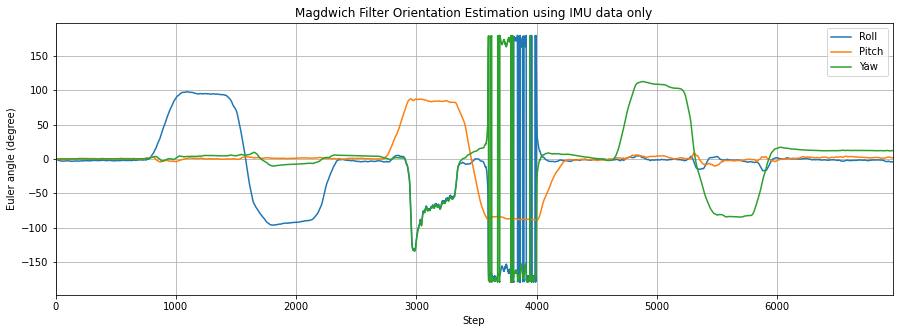

In [5]:
# Magdwich AHRS filter result plotting
plt.figure(figsize=(15,5))
plt.plot(euler_hist1)
plt.legend(['Roll','Pitch','Yaw'])
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Magdwich Filter Orientation Estimation using IMU data only')

## 3.3.  Magdwich AHRS with IMU + Magnetometer measurement

In [6]:
# Magdwich AHRS with IMU + Magnetometer
# All row vector operation
# Magdwich Program Paramter Setting
SamplPeriod = 1/256
beta = 0.05  # beta가 커질수록 estimation이 noisy해 진다.
q = np.array([1.0, 0.0, 0.0, 0.0]) # initial quaternion value
totalLen = Accelerometer.shape[0]
q_hist2 = np.zeros((totalLen,4))
euler_hist2 = np.zeros((totalLen,3))

for i in range(totalLen):
    
    q = Magdwich_IMU_Magnetometer(Accelerometer[i,:],Gyroscope[i,:],Magnetometer[i,:], q,beta,SamplPeriod)
    q_hist2[i, :]= q    
    euler_hist2[i,:] = np.rad2deg(quaternion_to_euler(q))    

Text(0.5, 1.0, 'Magdwich Filter Orientation Estimation using IMU data + Magnetometer')

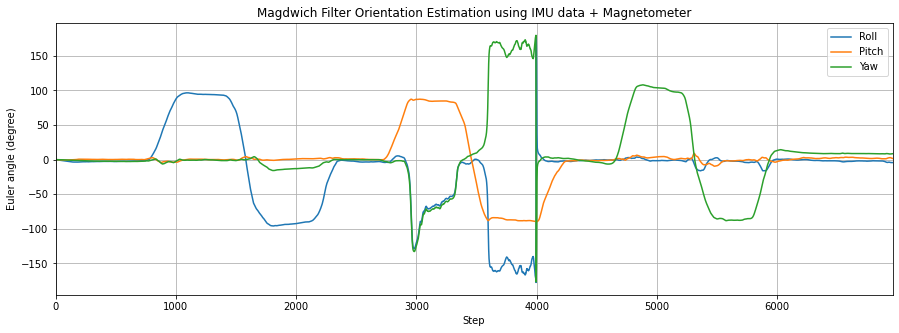

In [7]:
plt.figure(figsize=(15,5))
plt.plot(euler_hist2)
plt.legend(['Roll','Pitch','Yaw'])
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Magdwich Filter Orientation Estimation using IMU data + Magnetometer')